# Analysis
The key variable to judge success of offers and dependent variable for predictive modeling is incremental spend.
Other variables were considered, such as:
* Offer completion - will be looked at in the descriptives. Offer completion is a good proxy for how attractive consumers find an offer. However, from a business perspoective it is not as relevant as incremental spend, because it is possible that offers influence spend even when a consumer does not complete the offer. In addition, there is no offer completion for purely informational offers.
* Average hourly spend - A metric that considers the behavioural change (likely increase/potentially decrease in spend by the hour) during awareness. This can be compared to times when a consumer is not aware of any offer. As this metric does not factor in for *how long* a consumer sustains a higher level of spend, it does not tell the business what revenue it can make from an offer, though.
* Net total/incremental spend - A way to understand the net impact on the business better by deducting the reward amount from the total spend. However, this is a potentially poor proxy. For BOGO, it is unlikely that the consumer would have purchased two of the same product, and the cost to the company is hence not the revenue foregone, but the actual production cost of the product. In comparison, for the discount, the cost is the actual revenue foregone. There might also be other costs associated with the offers, like e.g. distribution cost. As costs are unknown, it was decided to work with incremental revenue.

These variables are contained in the analysis_df in case one wants to explore these variables further.

In [355]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import os
import pylab
import itertools
#% matplotlib inline
from pandasql import sqldf
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import statsmodels.api as sm

## Read in data and do basic data manipulation and cleaning

#### Read in data

In [306]:
# Read in the file
analysis_df = pd.read_csv(r'2021_12_27_analysis_df.csv')

In [293]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [307]:
analysis_df

,Unnamed: 0,person,block_id,hour,amount,hourly_avg,group,baseline_spend_during_awareness_time,incremental_spend,hourly_avg_during_nonawareness,...,time_lag_completion,time_lag_completion_to_expiry,gender,age,id,became_member_on,income,membership_duration,net_spend,net_spend_hourly_avg
0,0,68be06ca386d4c31939f3a4f0e3dd783,no_offer,231.0,0.00,0.000000,c,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,-1785,0.00,0.000000
1,1,0610b486422d4921ae7d2bf64640c50b,no_offer,714.0,77.01,0.107857,c,NaN,NaN,NaN,...,NaN,NaN,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,-1632,77.01,0.107857
2,2,38fe809add3b4fcf9315a9694bb96ff5,no_offer,545.0,14.30,0.026239,c,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,-1270,14.30,0.026239
3,3,78afa995795e4d85b5d9ceeca43f5fef,no_offer,459.0,68.27,0.148736,c,NaN,NaN,NaN,...,NaN,NaN,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,-1699,68.27,0.148736
4,4,a03223e636434f42ac4c3df47e8bac43,no_offer,291.0,3.56,0.012234,c,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,-1612,3.56,0.012234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66442,66442,fffad4f4828548d1b5583907f2e9906b,76614,31.0,6.97,0.224839,t,3.292786,3.677214,0.106219,...,30.0,84.0,M,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,1.97,0.063548
66443,66443,fffad4f4828548d1b5583907f2e9906b,76615,7.0,12.18,1.740000,t,0.743532,11.436468,0.106219,...,6.0,12.0,M,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,7.18,1.025714
66444,66444,ffff82501cea40309d5fdd7edcca4a07,76616,25.0,22.88,0.915200,t,7.112769,15.767231,0.284511,...,24.0,210.0,F,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,17.88,0.715200
66445,66445,ffff82501cea40309d5fdd7edcca4a07,76617,31.0,15.57,0.502258,t,8.819834,6.750166,0.284511,...,30.0,120.0,F,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,13.57,0.437742


#### Create better identifier for offers in order to make graphs more meaningful

In [308]:
# Create a variable that identifies offers and gives some descriptive context:
# type_difficulty_reward_#channels
event_descriptor_dict = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo_10_10_3',
                        '0b1e1539f2cc45b7b9fa7c272da2e1d7':'disc_20_5_2',
                        '5a8bc65990b245e5a138643cd4eb9837':'info_0_0_2',
                        '3f207df678b143eea3cee63160fa8bed':'info_0_0_4',
                        '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo_10_10_4',
                        'f19421c1d4aa40978ebb69ca19b0e20d':'bogo_5_5_4',
                        'fafdcd668e3743c1bb461111dcafc2a4':'disc_10_2_4',
                        '2298d6c36e964ae4a3e7e9706d1fb8c2':'disc_7_3_4',
                        '2906b810c7d4411798c6938adc9daaa5':'disc_10_2_3',
                        '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo_5_5_3'}

analysis_df['offer_descriptor'] = analysis_df['event_offer_id'].map(event_descriptor_dict)

In [309]:
# Create a pure treatment dataframe
analysis_df_t = analysis_df.loc[analysis_df['group'] == 't']

In [321]:
analysis_df_t

,Unnamed: 0,person,block_id,hour,amount,hourly_avg,group,baseline_spend_during_awareness_time,incremental_spend,hourly_avg_during_nonawareness,...,age,id,became_member_on,income,membership_duration,net_spend,net_spend_hourly_avg,offer_descriptor,offer_valid_until_exceeding_experiment,outlier
17000,17000,0009655768c64bdeb2e877511632db8f,1,61.0,8.570,0.140492,t,9.783228,-1.213228,0.160381,...,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1717,8.570,0.140492,info_0_0_4,432.0,0
17001,17001,0009655768c64bdeb2e877511632db8f,2,49.0,22.160,0.452245,t,7.858659,14.301341,0.160381,...,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1717,22.160,0.452245,info_0_0_2,240.0,0
17002,17002,00116118485d4dfda04fdbaba9a87b5c,5,73.0,0.000,0.000000,t,0.520157,-0.520157,0.007125,...,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1348,0.000,0.000000,bogo_5_5_4,288.0,0
17003,17003,00116118485d4dfda04fdbaba9a87b5c,6,67.0,0.000,0.000000,t,0.477404,-0.477404,0.007125,...,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1348,0.000,0.000000,bogo_5_5_4,696.0,0
17004,17004,0011e0d4e6b944f998e987f904e8c1e5,7,145.0,11.025,0.076034,t,18.524157,-7.499157,0.127753,...,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,-1454,6.025,0.041552,disc_20_5_2,648.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66442,66442,fffad4f4828548d1b5583907f2e9906b,76614,31.0,6.970,0.224839,t,3.292786,3.677214,0.106219,...,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,1.970,0.063548,bogo_5_5_4,120.0,0
66443,66443,fffad4f4828548d1b5583907f2e9906b,76615,7.0,12.180,1.740000,t,0.743532,11.436468,0.106219,...,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,7.180,1.025714,bogo_5_5_4,528.0,0
66444,66444,ffff82501cea40309d5fdd7edcca4a07,76616,25.0,22.880,0.915200,t,7.112769,15.767231,0.284511,...,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,17.880,0.715200,disc_20_5_2,408.0,0
66445,66445,ffff82501cea40309d5fdd7edcca4a07,76617,31.0,15.570,0.502258,t,8.819834,6.750166,0.284511,...,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,13.570,0.437742,disc_10_2_3,504.0,0


#### Remove all awareness period where the offer was not completed or did not expire during the analysis timeframe

In [291]:
analysis_df_t.dtypes

Unnamed: 0                                int64
person                                   object
block_id                                 object
hour                                    float64
amount                                  float64
hourly_avg                              float64
group                                    object
baseline_spend_during_awareness_time    float64
incremental_spend                       float64
hourly_avg_during_nonawareness          float64
event_offer_id                           object
offer received                          float64
offer viewed                            float64
offer completed                         float64
event_reward                            float64
offer_type                               object
offer_reward                            float64
offer_duration                          float64
offer_valid_until                       float64
offer_difficulty                        float64
email                                   

In [311]:
analysis_df_t['offer_valid_until_exceeding_experiment'] = analysis_df_t['offer_duration'] + analysis_df_t['offer received']

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [312]:
# Remove offers where the outcome is unclear at the end of the experiment
analysis_df_t = analysis_df_t.loc[analysis_df_t['offer_valid_until_exceeding_experiment'] <= transcript['time'].max()]

#### Remove outliers of incremental spend
Rationale: Some respondents have oddly high values in transaction records. Potentially, they bought for a large group of people, or it is a data entry error. These records can lead to very high or very low incremental spend. They will heavily bias averages and need to be removed. 
* The **histogram** below shows the distribution of very high and very low values to get a feeling for the magnitudes. 
* The **Q-Q plot** shows that the data is not normally distributed (it is " too narrow", i.e. it has lower variance than a normal distribution) and hence the way to remove outliers should be using the IQR (see: Jason Brownlee on April 25, 2018 in Data Preparation - How to Remove Outliers for Machine Learning - Machine Learning Matery: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/) 
* The **boxplot** shows that the extreme values are largely considered outliers when using a IQR removal approach (see section *whis* for definition here: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html)

Using the usual 1.5 * IQR approach, 7.7% of the sample are removed as outliers. This is a rather high value, considering that when using the Standard Deviation method, between 2 and 4 standard deviations are used to define outliers, hence leading to a data loss of max. 5%. The factor by which the IQR is multiplied was hence increased to 3, which means that 2.34% of the data was classified as outliers. The cut-offs still seem high, but possible at -37 and 48.

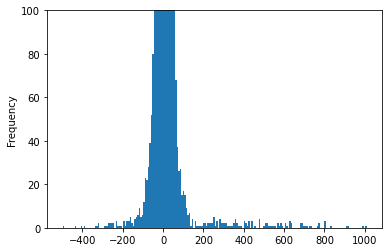

In [314]:
# Source Stackkoverflow: https://stackoverflow.com/questions/38424459/set-y-axis-limit-in-pandas-histogram
# Question by Andy Toulis: https://stackoverflow.com/users/6369225/andy-toulis
# Answer by Martin Thoma: https://stackoverflow.com/users/562769/martin-thoma
analysis_df_t['incremental_spend'].plot.hist(ylim=(0,100), bins = 200);

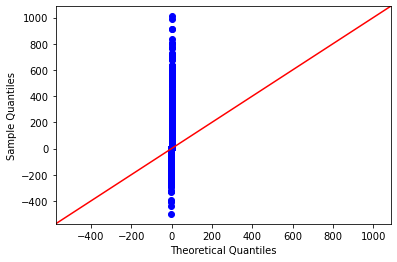

In [315]:
# Normal distribution? Q-Q plot
sm.qqplot(analysis_df_t['incremental_spend'], line = '45')
pylab.show()

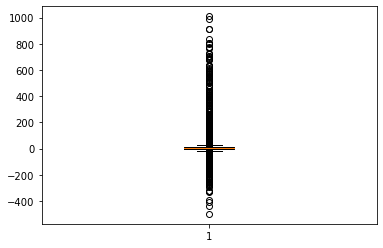

In [316]:
# Outliers ("flyers") in the data
plt.boxplot(analysis_df_t['incremental_spend']);

In [317]:
# Removing the outliers
# Source: Jason Brownlee on April 25, 2018 in Data Preparation - How to Remove Outliers for Machine Learning - Machine Learning Matery: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

q25 = np.percentile(analysis_df_t['incremental_spend'], 25)
q75 = np.percentile(analysis_df_t['incremental_spend'], 75)
iqr = q75 - q25
cut_off = iqr * 3
bottom_cut_off = q25 - cut_off
top_cut_off = q75 + cut_off
print("bottom cut off is: ", bottom_cut_off)
print("top cut off is: ", top_cut_off)

bottom cut off is:  -37.504245705101184
top cut off is:  47.806031935075886


In [318]:
analysis_df_t['outlier'] = 0
analysis_df_t.loc[(analysis_df_t['incremental_spend'] < bottom_cut_off) | (analysis_df_t['incremental_spend'] > top_cut_off), 'outlier'] = 1

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\j\Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [319]:
# Check number of outliers
analysis_df_t['outlier'].value_counts()

0    42571
1     1046
Name: outlier, dtype: int64

In [320]:
# Create df without outliers
analysis_df_t = analysis_df_t.loc[analysis_df_t['outlier'] == 0]

## Descriptive Analyses
**Completion:** Based on the descriptive statistics below show, discounts get completed more frequently than BOGO offers. 

**Incremental spend:** Despite discounts being completed more often, it is a BOGO offer (difficulty 10, reward 10, channels 3) that, on average, has the highest incremental spend. Maybe surprisingly, both informational offers show a high average incremental spend, too. When looking at distributions for informational offers, the spikes around the origin show that many customers do not change their spend as compared to non-offer-aware times, however. In comparison, for BOGO and discounts, one can spot spikes in the distribution at the value of difficulty (i.e. the money the customer needs to spend to complete the offer).

**Completion and incremental spend:** It could be possible that simple awareness already leads to positive incremental spend. This is not the case. The data shows that only completed offers are, on average, associated with higher incremental spend. One could therefore argue that the company should try to only target consumers that are likely to complete an offer. If the company was successful in this targeting and 100% of those who receive the offer and are aware complete it, then the best offer for the company would be another one - quite logically one with high difficulty (discount, difficulty 10, reward 5, channels 2). 

**Further analysis:**
As there will be an unknown costs associated with an offer, the predictive modeling analysis analysis will be using incremental spend of all who were aware of the offer as dependent variable rather than offer completion. This will allow the company to see who is worth targeting and give the company the flexibility to adjust monetary thresholds of when a person will be sent an offer flexibly and based on cost. By using this logic, the company is likely to automatically pick people who are likely to complete the offer.

#### Check base sizes
to assure that for each group I am interested in, base sizes are large enough to draw conclusions

In [324]:
pd.DataFrame(analysis_df_t.groupby(['offer_type']).size())

,0
offer_type,
bogo,19627
discount,13543
informational,9401


In [325]:
pd.DataFrame(analysis_df_t.groupby(['offer_descriptor']).size())

,0
offer_descriptor,
bogo_10_10_3,4691
bogo_10_10_4,6288
bogo_5_5_3,2659
bogo_5_5_4,5989
disc_10_2_3,2738
disc_10_2_4,4150
disc_20_5_2,1553
disc_7_3_4,5102
info_0_0_2,5816


#### Understand offer completion
as an indicator for how attractive a BOGO and discount offer are to consumers.
Consumers do more often complete the discount than the BOGO offers.

In [326]:
analysis_df_t[['offer_type','was_completed']].groupby(['offer_type']).mean()

,was_completed
offer_type,
bogo,0.442656
discount,0.637525
informational,0.000000


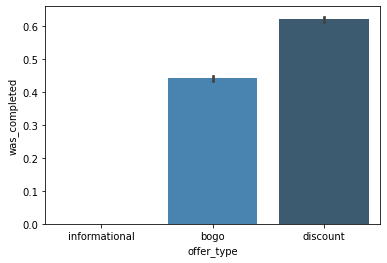

In [288]:
# How often do offers get completed (note: completion is not defined for informational offers)?
sns.barplot(x = analysis_df_t_o['offer_type'], y = analysis_df_t_o['was_completed'], palette="Blues_d");

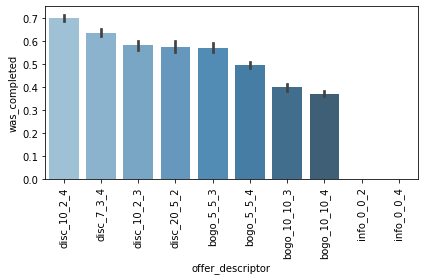

In [327]:
# Source Stackoverflow: https://stackoverflow.com/questions/31859285/rotate-tick-labels-for-seaborn-barplot
# Question by Laurennmc: https://stackoverflow.com/users/5198702/laurennmc
# Answer by wordsforthewise: https://stackoverflow.com/users/4549682/wordsforthewise

# Source for ordering is Stackoverflow: https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering
# Question by vladkras: https://stackoverflow.com/users/1713660/vladkras
# Answer by Jeremy: https://stackoverflow.com/users/674301/jeremy

grp_order = analysis_df_t.groupby('offer_descriptor').was_completed.agg('mean').sort_values(ascending = False).index
sns.barplot(x = analysis_df_t['offer_descriptor'], y = analysis_df_t['was_completed'], order=grp_order, palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout();

#### Understand incremental spend
to assess which offer type has the biggest impact on business revenue.
When plotting distributions, the graphs for BOGO and discount exhibit peaks at the difficulty level, i.e. the amount of money that needs to be spent to complete the offer. For informational offers, the graphs show more extreme maxima at/close to the origin, showing that many respondents did not change their behaviour as a consequency of the advertisement.

In [398]:
# Incremental spend
pd.DataFrame(analysis_df_t.groupby(['offer_descriptor','offer_type','offer_difficulty', 'offer_reward', 'email', 'mobile','social','web']).agg({'incremental_spend':[np.mean, np.median]}).reset_index().sort_values(by=[('incremental_spend','mean')], ascending = False))

offer_descriptor     offer_type offer_difficulty offer_reward email mobile  \
                                                                               
6      disc_20_5_2       discount             20.0          5.0   1.0    0.0   
5      disc_10_2_4       discount             10.0          2.0   1.0    1.0   
0     bogo_10_10_3           bogo             10.0         10.0   1.0    1.0   
7       disc_7_3_4       discount              7.0          3.0   1.0    1.0   
1     bogo_10_10_4           bogo             10.0         10.0   1.0    1.0   
4      disc_10_2_3       discount             10.0          2.0   1.0    1.0   
2       bogo_5_5_3           bogo              5.0          5.0   1.0    1.0   
3       bogo_5_5_4           bogo              5.0          5.0   1.0    1.0   
8       info_0_0_2  informational              0.0          0.0   1.0    1.0   
9       info_0_0_4  informational              0.0          0.0   1.0    1.0   

  social  web incremental_spend            
                           mean    median  
6    0.0  1.0          7.371040  5.736856  
5    1.0  1.0          6.297533  6.475318  
0    1.0  0.0          5.442909  4.638487  
7    1.0  1.0          4.855819  4.739789  
1    1.0  1.0          4.716083  3.138796  
4    0.0  1.0          4.675288  4.518141  
2    0.0  1.0          4.152968  3.730000  
3    1.0  1.0          4.047608  3.085326  
8    1.0  0.0          3.581101  0.000000  
9    0.0  1.0          3.085520  0.000000

In [399]:
# Charting distributions of incremental spend
b1 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_10_10_3']['incremental_spend']
b2 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_10_10_4']['incremental_spend']
b3 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_5_5_3']['incremental_spend']
b4 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_5_5_4']['incremental_spend']
d1 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_20_5_2']['incremental_spend']
d2 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_10_2_4']['incremental_spend']
d3 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_10_2_3']['incremental_spend']
d4 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_7_3_4']['incremental_spend']
i1 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'info_0_0_2']['incremental_spend']
i2 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'info_0_0_4']['incremental_spend']

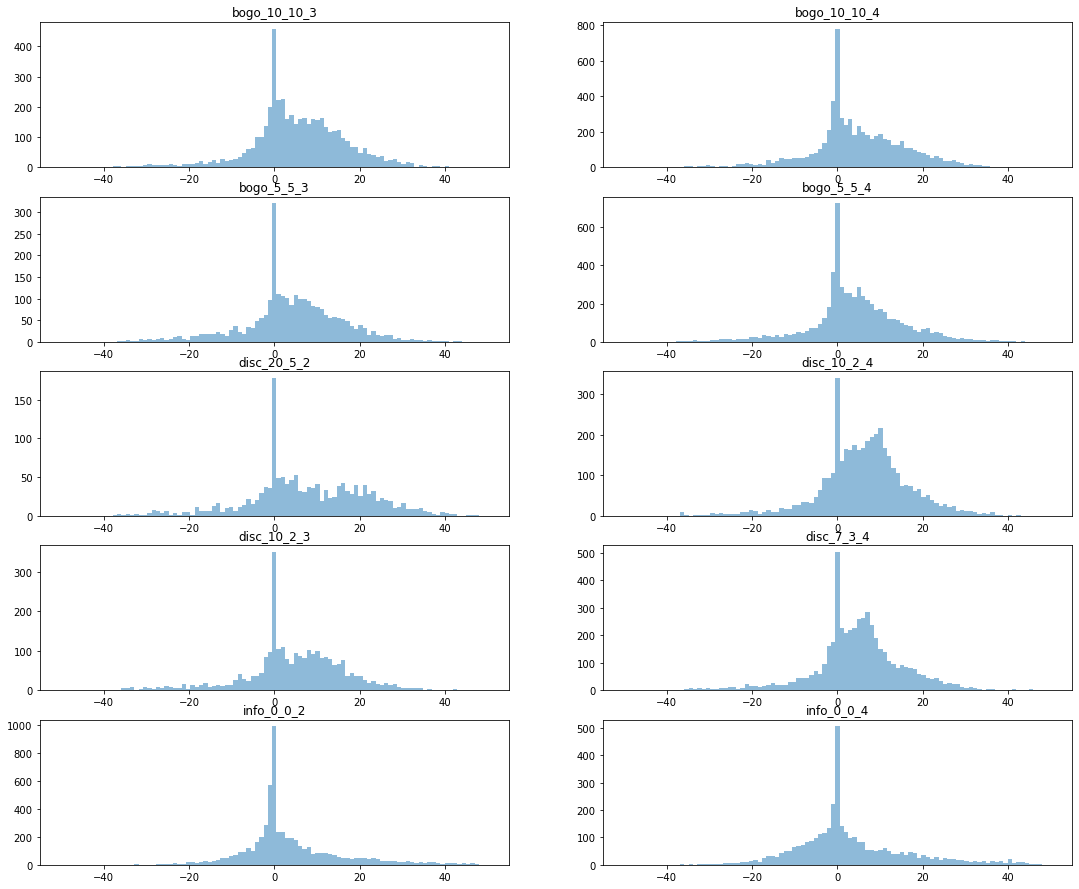

In [330]:
bins = np.linspace(-50, 50, 100)

fig, axs = plt.subplots(5,2) #,sharex=True, sharey=True)
fig.set_size_inches(18.5, 15.5)
ax_b1 = axs[0, 0].hist(b1, bins, alpha=0.5, label='bogo_10_10_3')
axs[0, 0].set_title('bogo_10_10_3')
ax_b2 = axs[0, 1].hist(b2, bins, alpha=0.5, label='bogo_10_10_4')
axs[0, 1].set_title('bogo_10_10_4')
ax_b3 = axs[1, 0].hist(b3, bins, alpha=0.5, label='bogo_5_5_3')
axs[1, 0].set_title('bogo_5_5_3')
ax_b4 = axs[1, 1].hist(b4, bins, alpha=0.5, label='bogo_5_5_4')
axs[1, 1].set_title('bogo_5_5_4')

ax_d1 = axs[2, 0].hist(d1, bins, alpha=0.5, label='disc_20_5_2')
axs[2, 0].set_title('disc_20_5_2')
ax_d2 = axs[2, 1].hist(d2, bins, alpha=0.5, label='disc_10_2_4')
axs[2, 1].set_title('disc_10_2_4')
ax_d3 = axs[3, 0].hist(d3, bins, alpha=0.5, label='disc_10_2_3')
axs[3, 0].set_title('disc_10_2_3')
ax_d4 = axs[3, 1].hist(d4, bins, alpha=0.5, label='disc_7_3_4')
axs[3, 1].set_title('disc_7_3_4')

ax_i1 = axs[4, 0].hist(i1, bins, alpha=0.5, label='info_0_0_2')
axs[4, 0].set_title('info_0_0_2')
ax_i2 = axs[4, 1].hist(i2, bins, alpha=0.5, label='info_0_0_4')
axs[4, 1].set_title('info_0_0_4');

#### Understand the impact of completion on incremental spend
to assess if simply knowing about an offer already leads to higher spend.
This is not the case. Average incremental spend is negative for those who do not complete the offer, meaning that these people spend less than they do when they are not aware of any offers.

If the company was better at targeting those who will complete an offer, the incremental spend would be best for the discount at difficulty 20 and reward 5.

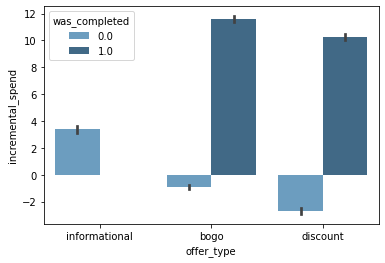

In [331]:
# Does only being aware of an offer w/o completing it also lead to positive incremental spend
sns.barplot(x = analysis_df_t['offer_type'], y = analysis_df_t['incremental_spend'], hue = analysis_df_t['was_completed'], palette="Blues_d");

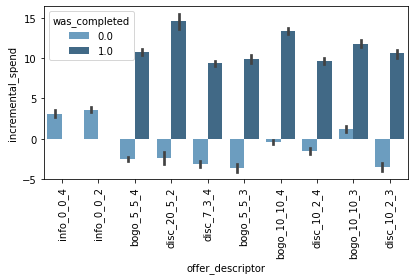

In [332]:
sns.barplot(x = analysis_df_t['offer_descriptor'], y = analysis_df_t['incremental_spend'], hue = analysis_df_t['was_completed'], palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout();

## Kruskal-Wallis Test
The data for the 10 offers is not normally distributed, as can easily be seen from the spikes at 0. Therefore, a non-parametric test needs to be used to establish if the offer success, measured as incremental spend, differs between offers. The Kruskal-Wallis test is the non-parametric counterpart to a one-way ANOVA. It assesses if the medians of two or more groups are statistically significantly different from each other. A group in this case is defined by the offer, hence there are ten groups.

The Kruskal-Wallis test assumes that the groups are independent. The alternative where groups are not independent is the Friedman test. It can be argued that the groups in this data are neither truly dependent nor truly independent, because some respondents might be in various offer groups, whilst others won't. Therefore, this assumption of the Kruskal-Wallis test is partially violated. However, there is no test for the "mixed" scenario. Therefore the test is still used as best option. 

Sources: 
Richard A. Armstrong and Anthony C. Hilton, Nonparametric Analysis of Variance, 12 November 2010, https://onlinelibrary.wiley.com/doi/10.1002/9780470905173.ch24
No author, Kruskal-Wallis H Test using SPSS Statistics, no date, https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php

##### Q-Q plots? Standardization?
#### Discuss if groups are independent for a one-way ANOVA

#### Assumptions:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
* The samples are independent.
* Each sample is from a normally distributed population.
* The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

#### Visual inspection of medians

In [341]:
# Look at medians
print("b1 median: ",b1.median())
print("b2 median: ",b2.median())
print("b3 median: ",b3.median())
print("b4 median: ",b4.median())
print("d1 median: ",d1.median())
print("d2 median: ",d2.median())
print("d3 median: ",d3.median())
print("d4 median: ",d4.median())
print("i1 median: ",i1.median())
print("i2 median: ",i2.median())

b1 median:  4.638486842105264
b2 median:  3.1387956204379566
b3 median:  3.73
b4 median:  3.0853260869565218
d1 median:  5.736855670103093
d2 median:  6.475317585026888
d3 median:  4.5181410758414255
d4 median:  4.7397891566265065
i1 median:  0.0
i2 median:  0.0


#### Create arrays to feed into test

In [401]:
def make_array(s):
    '''
    Takes in a series and outputs as array
    '''
    array = s[~s.isna()].to_numpy()
    return array

In [404]:
b1 = make_array(b1)
b2 = make_array(b2)
b3 = make_array(b3)
b4 = make_array(b4)
d1 = make_array(d1)
d2 = make_array(d2)
d3 = make_array(d3)
d4 = make_array(d4)
i1 = make_array(i1)
i2 = make_array(i2)

#### Kruskal-Wallis test
to see if there are any differences between groups. p < 0.05, hence there are differences.

In [335]:
statistic, p_value = stats.kruskal(b1, b2, b3, b4, d1, d2, d3, d4, i1, i2)

In [336]:
print("F: ",statistic)
print("p: ",p_value)

F:  913.8614846235372
p:  6.377700634620933e-191


#### Post hoc test with Mann-Whitney U test and Bonferroni adjustment
to see between which offers these significant differences exist at alpha = 0.05. To account for multiple testing, alpha is Bonferroni-adjusted.
The **two** "top offers" are d1 and d2, which are not statistically significantly different from each other. So are a few other offer combinations. 

In [358]:
all_arrays = {"b1":b1, "b2":b2, "b3":b3, "b4":b4, "d1":d1, "d2":d2, "d3":d3, "d4":d4, "i1":i1, "i2":i1}

In [359]:
# Create all pairs that are needed
# Source Stackoverflow: https://stackoverflow.com/questions/11905573/getting-all-combinations-of-key-value-pairs-in-python-dict
# Question by Andrew C: https://stackoverflow.com/users/1335244/andrew-c
# Answer by Jolly Jumper: https://stackoverflow.com/users/1590392/jolly-jumper
pairs = list(map(dict, itertools.combinations(all_arrays.items(), 2)))

In [382]:
results_sig_diff = {}
results_not_sig_diff = {}
for i in pairs:
    combo = list(i)
    a = list(i)[0]
    b = list(i)[1]
    statistic, pvalue = stats.mannwhitneyu(i[a],i[b])
    # keeping those pairs that are statistically significalntly different using Bonferroni adjustment
    if pvalue < 0.05/len(pairs):
        results_sig_diff[str(a)+'_'+str(b)] = pvalue
    else:
        results_not_sig_diff[str(a)+'_'+str(b)] = pvalue

In [383]:
results_not_sig_diff

{'b1_d3': 0.029775519967164685,
 'b1_d4': 0.021961062057059385,
 'b2_b3': 0.38666680205957976,
 'b2_b4': 0.006674248818760421,
 'b2_d3': 0.02482836259350674,
 'b3_b4': 0.03555384295150148,
 'b3_d3': 0.024003621303899624,
 'b3_d4': 0.0035019301230954755,
 'd1_d2': 0.025463396764140254,
 'd3_d4': 0.45367789566043565,
 'i1_i2': 0.49999889832564903}